In [1]:
# a few packages we need to import
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
from tqdm import tqdm
import torch
import pendulum

torch.random.manual_seed(415)

The goal of this homework is to implement the Q-learning with a neural network for the Q function to solve the inverted pendulum problem.

<img src='pendulum.png' width="120">

In the following, we write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system.

## System dynamics
* The system dynamics is implemented in the `pendulum.py` function. The dynamics is implemented in `pendulum.step`.
* The allowed control inputs are $[-5,0,5]$

## Cost function
The goal is to find a policy that minimizes the following cost
$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls



## Q-learning algorithm to implement
For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$


## Parameters:
* Episode length 100 steps
* Discount factor $\alpha = 0,99$
* Learning rate (for SGD) 0.1
* $\epsilon = 0.1$



## Using PyTorch
You need to install and use PyTorch for the neural network and do the optimization. 

You may want to use the following functions:
* [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

The neural network is given below

In [2]:
## we define the neural network to be used for Q-learning
## 2 hidden layers with 64 nodes
## 2 inputs (state)
## 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

## we initialize the network parameters to 0
for params in q_function.parameters():
    params = torch.zeros_like(params)


### possible controls
possible_controls = np.array([-5.,0.,5.])

# Questions:
1. Implement the Q-learning algorithm described above
2. Test that it works with and without pushes using the code below
3. Plot the cost per episode (to visualize learning)
4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.
5. Describe the algorithm and put the plots in a short report (max 2 pages) and include a video of the pendulum.

## Testing
You can test your results with the code below which use the Q-function to create a controller send to the `animate_robot` function.
You can choose to save also a movie of the animation and toggle the animation with a disturbance.

In [ ]:
def cost_function(x, u):
    # Convert x to a PyTorch tensor if it's not already
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    if not isinstance(u, torch.Tensor):
        u = torch.tensor(u, dtype=torch.float32)

    # Compute the cost using PyTorch operations
    return 0.01 * (1 - torch.cos(x[0] - np.pi))**2 + 0.001 * x[1]**2 + 0.00001 * u**2

optimizer = torch.optim.SGD(q_function.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

cost_list = []  
loss_list = []

# We need to define the q-learning parameters
alpha = 0.99
epsilon = 0.1
episode_length = 100
learning_rate = 0.1
episodes = 20000


for episode in tqdm(range(episodes), desc='Running episodes'):
    x = torch.tensor([0., 0.])
    for step in range(episode_length):
        # Select u_n using an epsilon-greedy policy
        if np.random.rand() < epsilon:
            u_n = np.random.choice(possible_controls)
        else:
            u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float32).unsqueeze(0))).item()
            u_n = possible_controls[u_pred]

        # Compute the next state x_{n+1}
        x_next = pendulum.step(x, u_n)

        # Compute the target y_n
        g_value = cost_function(x, u_n)
        q_value = q_function(torch.as_tensor(x_next, dtype=torch.float32).unsqueeze(0)).detach()

        y = g_value + alpha * torch.min(q_value)
        

        # Update the Q-function
        q_value = q_function(torch.as_tensor(x, dtype=torch.float32).unsqueeze(0))
        target = q_value.clone().detach()
        u_index = np.where(possible_controls == u_n)[0][0]
        target[0, u_index] = y

        # Compute the loss
        loss = loss_fn(q_value, target)
        

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the state
        x = x_next
    loss_list.append(loss.item())
    cost_list.append(g_value.item())
    # # Print the status of the episode
    # if episode % 100 == 0:
    #     print(f"Episode {episode}, Step {step}, Loss {loss.item()}")


# def controller(x):


Running episodes: 100%|██████████| 20000/20000 [33:37<00:00,  9.91it/s]


In [4]:
x0 = np.zeros((2,1))
def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=False, save_movie=False)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAahhtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DSZliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFV
til7hBi79CSaTb0xDWuZN3nDq23yvHA3INZjOgNcsA87FgS7RxahBxc+OmniIFYF+j3coOCrpdCK
Pg6PUsYPPJIyvfy6GBthd1X3VUGikZO58pJ6STZmQo61urgqv/Mz2++KiAC5sx/LX9hIP+Jz5nrK
xZmwIf0L9lvYkaNH1tJGFyQxCNp585+r+VY0HRdzTao0GXib0Yejb1ibLn/aFU+pqchmsEiLH5bU
VgWe9U5bdbIILdv2ADr4WPbPqa1ddCsc1nlJlX5fytIl3wYVN5/1MHeAAsr2/t0zy/qjKaqmZU2n
0aDUHFsyVnSSAX2FgjQbte8AWB3EqbJLKBNPodNnMNMlVNrNoy49CSkJAianTx6Sg6aulnUTfO7S
o7EOAAADAAAG9QKIVBI9fVp8F/MZysfy/0R0hxRRcvjG6Swje2Jc2G5Qxeh2iGTNAmLiv14oliSH
mEmnHpAshUGYi5kTcErFrHHS51CKtTbDvlyPftQmopHQy003Mqk7QPWZ3Sl+cTfcWAg/QGrZN2Z5
4wfFcpFQQ9go5QGzmnqaYl5aiWMV5V84qSHyv+TYZYpFT0SgtuJ7cwTUBknC2JVyi3WThzQcq3r6
yvnDIFGetNCIuiXExF4tk1dOQIw4U5y/O2iUBgOwfzEFe/18xKCrOq1IFmYqnHlRjIe8l+UPcyT1
FR2tZ+ibayPsLtMJ7xEKMr7PO4xfOi2IN8QH/f9fFlrNcldJkbRUQwJP3uxtwX4MrimyC4FzKsxw
r+CYuJhwirj3/yj4L0Bp7jIGiWp1NGfNoUh/hpDAwTGvpMKuy2b4pUo/x+DgHRKTt70pJ6vsCLo3
tJu/Y/gALnNtg0+3wzqAAAADAAADAFBcAiRfcOz0yRLugrBtDopoJy2mbzNuv3t5RxMk6yay7q6C
76WNOJMKHu7y3A5hDuu6JqxJSkJhgIlmf7KbX/mm8b9p3P8xMZbGyjUchpHlyl4r6BTD03LvZsSo
H6v//9g1mZN4yrWYlNZK8P+kbBuM2SUuowPM5K3JySjgAK29qdYsNkvrB1wW8eQ/b7IxHlFFcJdO
YW/XrWU34x+Yv1yMjZhrtwAbiWGbRkJXXw6o9Rxu6WkdF/hIGDW6rbzpfz9Pwsuds8RN4jQae6yO
z90yKu+7gy/JfXpcguvUrPer1Mx6e0Q4+i4CQC0ww576qN3+XXao80GkO/evEP0hUVGGciEWNKRN
KLCtdEyxt7imicrVoiRKA17cPdnM/w7FkbA19yFPJf6naDBbVUDitiXtNLRFBrtObpHoDsCbenDG
gQl0/w7KN3wpLBhQ08CURsJqT52UAi8wO9YFkwFgZNr7yPcLZZ53Gos/ggbLJMKFVJL5hwLZ0zU8
Kr+O4Akb6LrHk2x0Rz62fRRnkkr72RvKAUJMV4+0W/yEZ3P8mPjPG4fYHH3X0EK6vWiIWD7asSUq
s/5r49+nz0UiPlTiDLPOX2Ms07ZN+uRTiO3wpRxQUE410z53Hg/V7GyoVGEqg53/inuts3APQPHK
976G5MkpAY0IzbHtFwP0t5H7gEbFbyLdPtptQV3qoxS7EWDQVwn9rvOp+TBz7rJfBDupvswF3SvB
BES09XIfYV2w5uW7XY4H87SJWXOzUlRphphvVed3WquKtXogh8xjqxFj21eW3PuWneSGs79aO0b8
atZqg1dChLReH9Ypv2xZsRGZW1NG0rlDLRJWAmceSDMBeKRw6DPOMiB+n85i9Q+v7XHlz2CfkFik
NzLVbw9PCLi/FlVbZzPkkjCs5B/rKaT0p1s2omcakokp2AUa7dsZ127ejASQyvdTGQVZsE1viY84
YAQAQ+4sNYlCeIgxHTLPib4hPIAXJbAZnLzrMwKf/tZuR1T//GX/S/booYeuoqIxfDm8WRjtSyXH
iA5GBSAEDoJT1xtnKI6fs9khV6p1POVIjuPxUc8XEK7mhMTeY5Iv2UtbTt75tmhEk9qJAAADAvQk
PG5nERmWc3MRBmM+HGPQ5b7qp20dAOP6Xt+n6HLAeRETogl9nC6vGr1YbQreBcAABLwcC99b7fDX
Hp+91nNMAAHcABwnrr51IMtyJmwAAyDHyWFlEJiNgdvDoMUdq5rlo42tAHctyhJujIvXz7zDLYl6
Genu58Re5dz9yyJWg0wtGyLadLmNXnap5PASrPxPmYb15OuM7Ps7Yr0T736Xk5GlH6DT8Hx6cxGX
OUSo1eeScKt9WbT6zpMIZNoy+wwh44aeT+7zoITe3b9uhldcUdBQWN6ZbooEAAhx7UGqxg0nURW9
CeUhQuuwmOkGL7TaLHsmyYbZc9HQFf4bCeK5O+VHB+ndp5oNXdZDBKCWUKgKBwyDuCko14+yvS3Z
x9ZMU2G0YrSztvgyYiuF9g6rRHN1HHzPv/OExlKx2dw8Ydi18HCeUS6sJFTJg+TRDkpH/50RtOM+
njRAG+XQjE787ZZL9FuqVpiL40xCRBjWgaCcCA5lBnaT1OQzGs5Vf/6sGa2M12bVqnl+/MzUAsLi
FidrlM2woLKhTyofI0Lqf

In [ ]:
x0 = np.zeros((2,1))
def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=True, save_movie=True)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAArudtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DSZliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFV
til7hBi79CSaTb0xDWuZN3nDq23yvHA3INZjOgNcsA87FgS7RxahBxc+OmniIFYF+j3coOCrpdCK
Pg6PUsYPPJIyvfy6GBthd1X3VUGikZO58pJ6STZmQo61urgqv/Mz2++KiAC5sx/LX9hIP+Jz5nrK
xZmwIf0L9lvYkaNH1tJGFyQxCNp585+r+VY0HRdzTao0GXib0Yejb1ibLn/aFU+pqchmsEiLH5bU
VgWe9U5bdbIILdv2ADr4WPbPqa1ddCsc1nlJlX5fytIl3wYVN5/1MHeAAsr2/t0zy/qjKaqmZU2n
0aDUHFsyVnSSAX2FgjQbte8AWB3EqbJLKBNPodNnMNMlVNrNoy49CSkJAianTx6Sg6aulnUTfO7S
o7EOAAADAAAG9QKIVBI9fVp8F/MZysfy/0R0hxRRcvjG6Swje2Jc2G5Qxeh2iGTNAmLiv14oliSH
mEmnHpAshUGYi5kTcErFrHHS51CKtTbDvlyPftQmopHQy003Mqk7QPWZ3Sl+cTfcWAg/QGrZN2Z5
4wfFcpFQQ9go5QGzmnqaYl5aiWMV5V84qSHyv+TYZYpFT0SgtuJ7cwTUBknC2JVyi3WThzQcq3r6
yvnDIFGetNCIuiXExF4tk1dOQIw4U5y/O2iUBgOwfzEFe/18xKCrOq1IFmYqnHlRjIe8l+UPcyT1
FR2tZ+ibayPsLtMJ7xEKMr7PO4xfOi2IN8QH/f9fFlrNcldJkbRUQwJP3uxtwX4MrimyC4FzKsxw
r+CYuJhwirj3/yj4L0Bp7jIGiWp1NGfNoUh/hpDAwTGvpMKuy2b4pUo/x+DgHRKTt70pJ6vsCLo3
tJu/Y/gALnNtg0+3wzqAAAADAAADAFBcAiRfcOz0yRLugrBtDopoJy2mbzNuv3t5RxMk6yay7q6C
76WNOJMKHu7y3A5hDuu6JqxJSkJhgIlmf7KbX/mm8b9p3P8xMZbGyjUchpHlyl4r6BTD03LvZsSo
H6v//9g1mZN4yrWYlNZK8P+kbBuM2SUuowPM5K3JySjgAK29qdYsNkvrB1wW8eQ/b7IxHlFFcJdO
YW/XrWU34x+Yv1yMjZhrtwAbiWGbRkJXXw6o9Rxu6WkdF/hIGDW6rbzpfz9Pwsuds8RN4jQae6yO
z90yKu+7gy/JfXpcguvUrPer1Mx6e0Q4+i4CQC0ww576qN3+XXao80GkO/evEP0hUVGGciEWNKRN
KLCtdEyxt7imicrVoiRKA17cPdnM/w7FkbA19yFPJf6naDBbVUDitiXtNLRFBrtObpHoDsCbenDG
gQl0/w7KN3wpLBhQ08CURsJqT52UAi8wO9YFkwFgZNr7yPcLZZ53Gos/ggbLJMKFVJL5hwLZ0zU8
Kr+O4Akb6LrHk2x0Rz62fRRnkkr72RvKAUJMV4+0W/yEZ3P8mPjPG4fYHH3X0EK6vWiIWD7asSUq
s/5r49+nz0UiPlTiDLPOX2Ms07ZN+uRTiO3wpRxQUE410z53Hg/V7GyoVGEqg53/inuts3APQPHK
976G5MkpAY0IzbHtFwP0t5H7gEbFbyLdPtptQV3qoxS7EWDQVwn9rvOp+TBz7rJfBDupvswF3SvB
BES09XIfYV2w5uW7XY4H87SJWXOzUlRphphvVed3WquKtXogh8xjqxFj21eW3PuWneSGs79aO0b8
atZqg1dChLReH9Ypv2xZsRGZW1NG0rlDLRJWAmceSDMBeKRw6DPOMiB+n85i9Q+v7XHlz2CfkFik
NzLVbw9PCLi/FlVbZzPkkjCs5B/rKaT0p1s2omcakokp2AUa7dsZ127ejASQyvdTGQVZsE1viY84
YAQAQ+4sNYlCeIgxHTLPib4hPIAXJbAZnLzrMwKf/tZuR1T//GX/S/booYeuoqIxfDm8WRjtSyXH
iA5GBSAEDoJT1xtnKI6fs9khV6p1POVIjuPxUc8XEK7mhMTeY5Iv2UtbTt75tmhEk9qJAAADAvQk
PG5nERmWc3MRBmM+HGPQ5b7qp20dAOP6Xt+n6HLAeRETogl9nC6vGr1YbQreBcAABLwcC99b7fDX
Hp+91nNMAAHcABwnrr51IMtyJmwAAyDHyWFlEJiNgdvDoMUdq5rlo42tAHctyhJujIvXz7zDLYl6
Genu58Re5dz9yyJWg0wtGyLadLmNXnap5PASrPxPmYb15OuM7Ps7Yr0T736Xk5GlH6DT8Hx6cxGX
OUSo1eeScKt9WbT6zpMIZNoy+wwh44aeT+7zoITe3b9uhldcUdBQWN6ZbooEAAhx7UGqxg0nURW9
CeUhQuuwmOkGL7TaLHsmyYbZc9HQFf4bCeK5O+VHB+ndp5oNXdZDBKCWUKgKBwyDuCko14+yvS3Z
x9ZMU2G0YrSztvgyYiuF9g6rRHN1HHzPv/OExlKx2dw8Ydi18HCeUS6sJFTJg+TRDkpH/50RtOM+
njRAG+XQjE787ZZL9FuqVpiL40xCRBjWgaCcCA5lBnaT1OQzGs5Vf/6sGa2M12bVqnl+/MzUAsLi
FidrlM2woLKhTyofI0Lqf

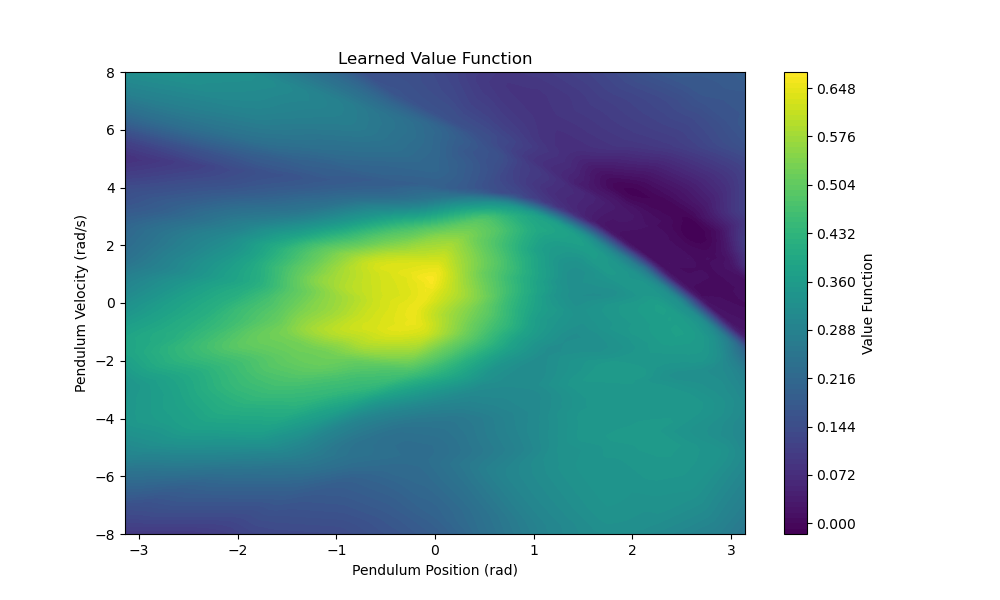

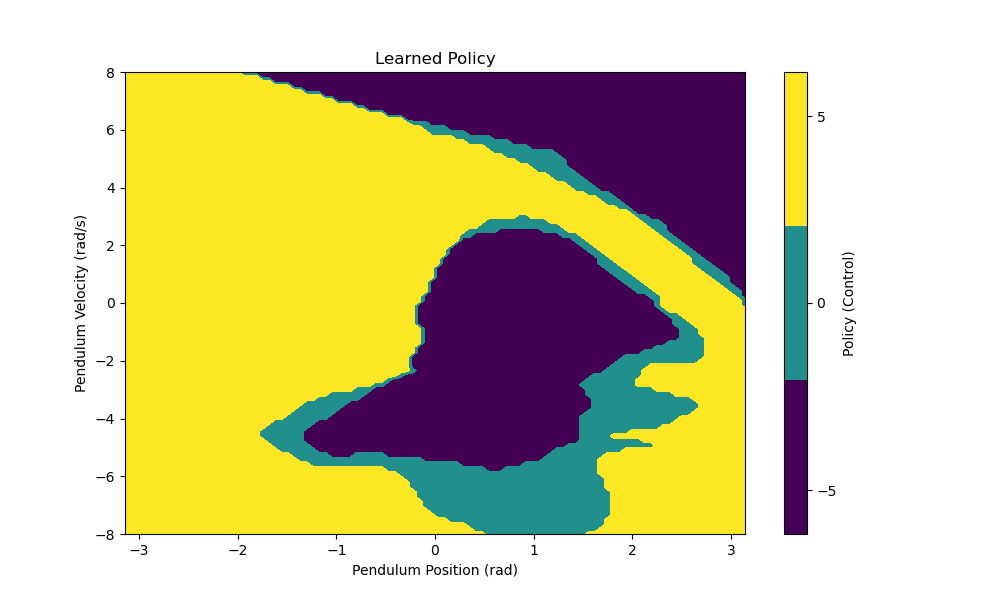

In [6]:
from matplotlib.colors import BoundaryNorm

def plot_value_function_and_policy(q_function, possible_controls, position_range=(-np.pi, np.pi), velocity_range=(-8, 8), grid_size=100):
    # Create a grid of positions and velocities
    positions = np.linspace(*position_range, grid_size)
    velocities = np.linspace(*velocity_range, grid_size)
    position_grid, velocity_grid = np.meshgrid(positions, velocities)

    # Initialize arrays for the value function and policy
    value_grid = np.zeros_like(position_grid)
    policy_grid = np.zeros_like(position_grid)

    # Evaluate the Q-function for each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([position_grid[i, j], velocity_grid[i, j]], dtype=torch.float32)
            q_values = q_function(state.unsqueeze(0)).detach().numpy().flatten()
            value_grid[i, j] = np.min(q_values)  # Value function
            policy_grid[i, j] = possible_controls[np.argmin(q_values)]  # Policy

    # Plot the value function
    plt.figure(figsize=(10, 6))
    plt.contourf(position_grid, velocity_grid, value_grid, levels=100)
    plt.colorbar(label='Value Function')
    plt.title('Learned Value Function')
    plt.xlabel('Pendulum Position (rad)')
    plt.ylabel('Pendulum Velocity (rad/s)')
    plt.show()

    # Plot the policy
    # Plot the policy
    plt.figure(figsize=(10, 6))

    # Define boundaries and colormap for the discrete policy values
    levels = [-6, -2.5, 2.5, 6]  # Boundaries for -5, 0, 5
    cmap = plt.cm.viridis
    norm = BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)

    contour = plt.contourf(position_grid, velocity_grid, policy_grid, levels=levels, cmap=cmap, norm=norm)
    cbar = plt.colorbar(contour, ticks=[-5, 0, 5])  # Set color bar ticks to match control values
    cbar.set_label('Policy (Control)')

    plt.title('Learned Policy')
    plt.xlabel('Pendulum Position (rad)')
    plt.ylabel('Pendulum Velocity (rad/s)')
    plt.show()


# Example usage
plot_value_function_and_policy(q_function, possible_controls)


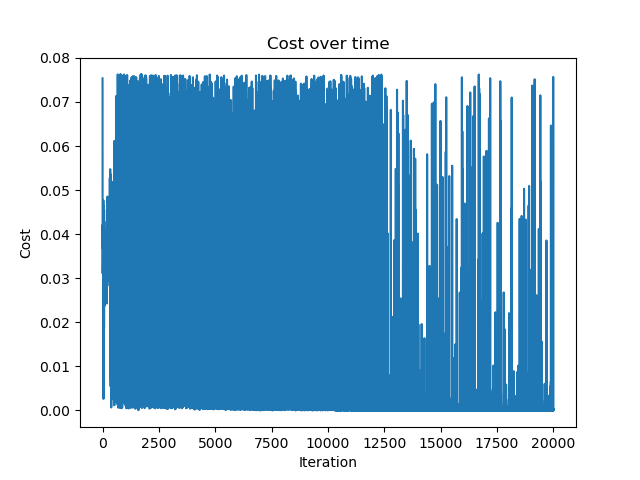

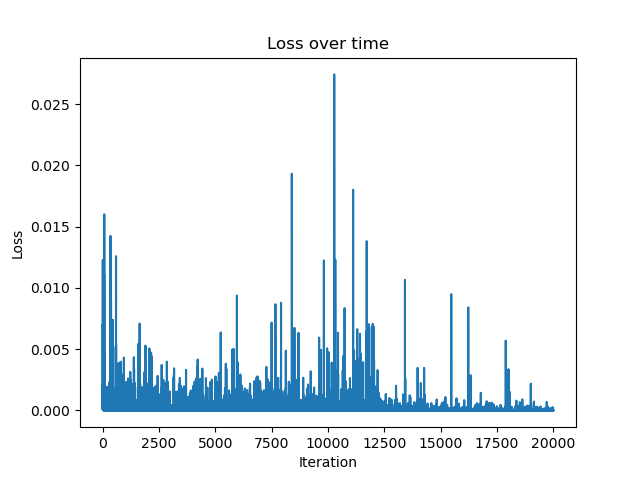

In [7]:
# Plot the cost and loss
plt.figure()
plt.plot(cost_list)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost over time')
plt.show()

plt.figure()
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.show()  
